In [16]:
# E-commerce Multimodal AI: Image Preprocessing Pipeline
# Week 2, Day 1: Advanced Image Processing for Fashion-MNIST

# Environment Setup and Dependencies
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import os
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Setting random seeds for reproductability
torch.manual_seed(42)
np.random.seed(42)

print("=== Image Preprocessing Pipeline Setup ===")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
  print(f"GPU device: {torch.cuda.get_device_name(0)}")

=== Image Preprocessing Pipeline Setup ===
PyTorch version: 2.6.0+cu124
CUDA available: False


In [17]:
# Load Fashion-MNIST Data
def load_fashion_mnist():
  """ Load Fashion-MNIST with basic transforms for analysis """

  # Basic Transform to Tensor(No pre-processing)

  basic_transform = transforms.Compose([
    transforms.ToTensor()
  ])

  # Load Datasets
  train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=basic_transform
  )

  test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=basic_transform
  )

  # Class Names

  class_names = [ 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]

  print(f"Training Samples: {len(train_dataset)}")
  print(f"Test Samples: {len(test_dataset)}")
  print(f"Image Shape: {train_dataset[0][0].shape}")
  print(f"Classes: {len(class_names)}")

  return train_dataset, test_dataset, class_names

# Load the data
train_data, test_data, classes = load_fashion_mnist()

Training Samples: 60000
Test Samples: 10000
Image Shape: torch.Size([1, 28, 28])
Classes: 10


 === Image Statistics Analysis === 
Analyzing 5000 random samples... 


100%|██████████| 5000/5000 [00:01<00:00, 3140.67it/s]


 Mean : 0.2863
 Standard Deviation : 0.3530
 Min : 0.0000
 Max : 1.0000

Per-Class Statistics: 
 T-shirt/top: Mean=0.3251, Std=0.3508
 Trouser: Mean=0.2221, Std=0.3431
 Pullover: Mean=0.3856, Std=0.3612
 Dress: Mean=0.2548, Std=0.3490
 Coat: Mean=0.3846, Std=0.3757
 Sandal: Mean=0.1350, Std=0.2607
 Shirt: Mean=0.3305, Std=0.3394
 Sneaker: Mean=0.1663, Std=0.2915
 Bag: Mean=0.3555, Std=0.3677
 Ankle boot: Mean=0.2954, Std=0.3699


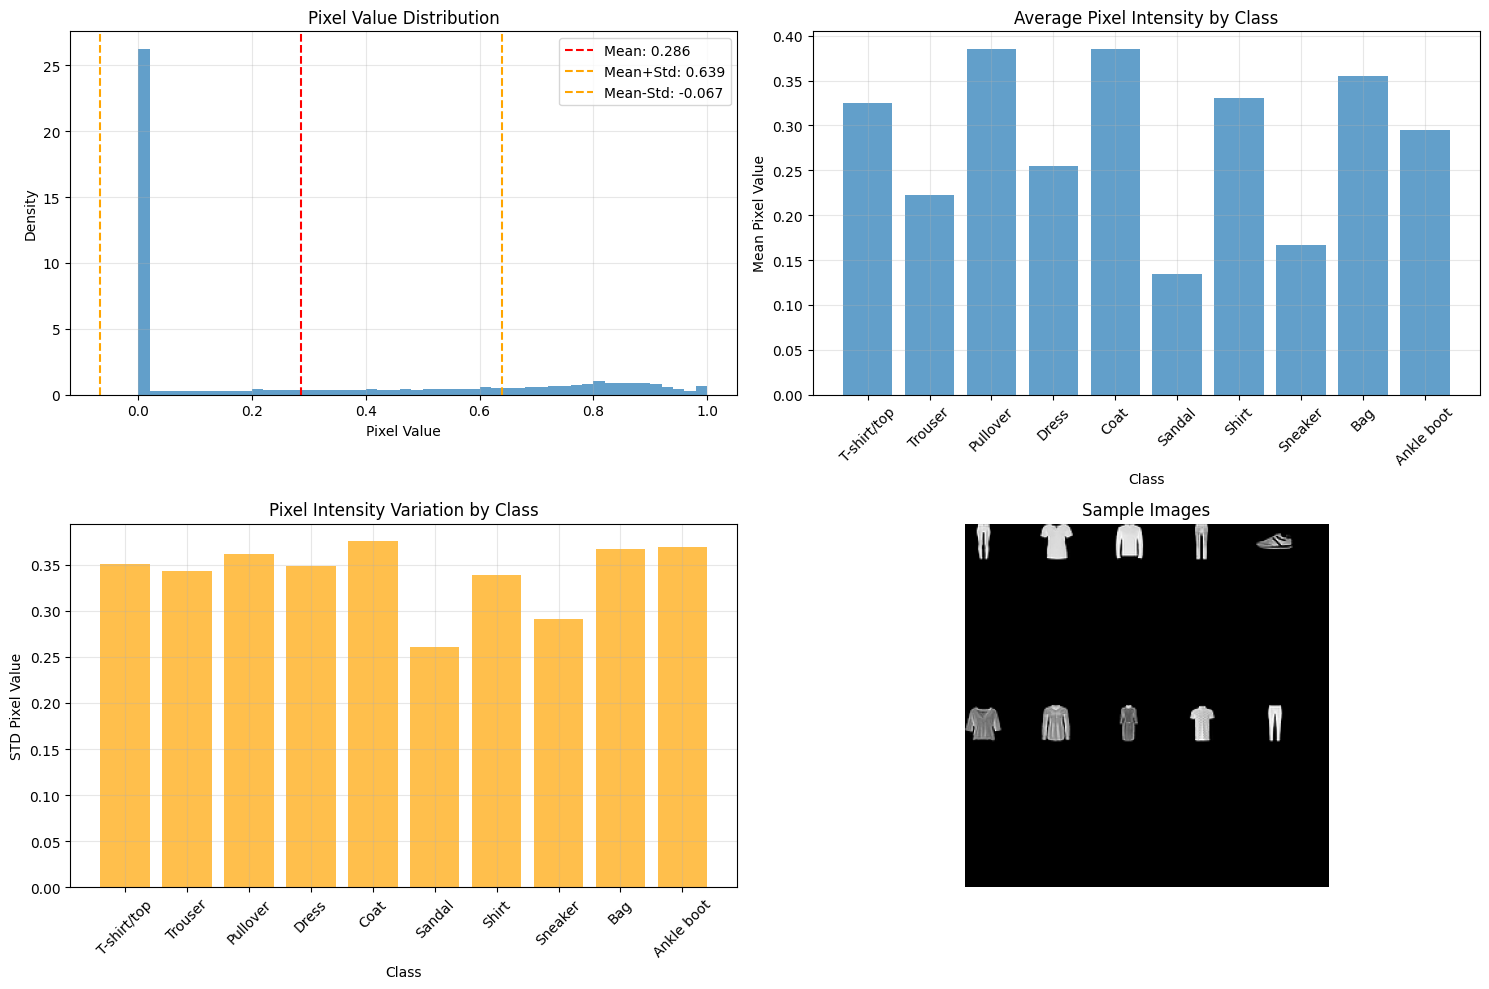

In [18]:
# Image Statistics Analysis
def analyse_image_statistics(dataset, class_names, sample_size=5000):
  """ Analyze Pixel Statistics for Proper Normalization """
  print(" === Image Statistics Analysis === ")

  # Sample Random Images for Analysis
  indices = np.random.choice(len(dataset), size=sample_size, replace=False)

  pixel_values = []
  class_stats = {i: [] for i in range(len(class_names))}

  print(f"Analyzing {sample_size} random samples... ")

  for idx in tqdm(indices):
    image, label = dataset[idx]
    pixel_values.extend(image.flatten().numpy())
    class_stats[label].extend(image.flatten().numpy())

  pixel_values = np.array(pixel_values)

  # Overall Statistics
  mean_pixel = pixel_values.mean()
  std_pixel = pixel_values.std()
  min_pixel = pixel_values.min()
  max_pixel = pixel_values.max()

  print(f" Mean : {mean_pixel:.4f}")
  print(f" Standard Deviation : {std_pixel:.4f}")
  print(f" Min : {min_pixel:.4f}")
  print(f" Max : {max_pixel:.4f}")

  # Per-Class Statistics
  class_means = []
  class_stds = []

  print(f"\nPer-Class Statistics: ")
  for class_idx, class_name in enumerate(class_names):
    if class_stats[class_idx]:
      class_pixels = np.array(class_stats[class_idx])
      class_mean = class_pixels.mean()
      class_std = class_pixels.std()
      class_means.append(class_mean)
      class_stds.append(class_std)
      print(f" {class_name}: Mean={class_mean:.4f}, Std={class_std:.4f}")

  # Visualizations
  fig, axes = plt.subplots(2, 2, figsize=(15, 10))

  # Pixel Value Distribution

  axes[0,0].hist(pixel_values, bins=50, alpha=0.7, density=True)
  axes[0,0].axvline(mean_pixel, color='red', linestyle='--', label=f'Mean: {mean_pixel:.3f}')
  axes[0,0].axvline(mean_pixel + std_pixel, color='orange', linestyle='--', label=f'Mean+Std: {mean_pixel+std_pixel:.3f}')
  axes[0,0].axvline(mean_pixel - std_pixel, color='orange', linestyle='--', label=f'Mean-Std: {mean_pixel-std_pixel:.3f}')
  axes[0,0].set_title('Pixel Value Distribution')
  axes[0,0].set_xlabel('Pixel Value')
  axes[0,0].set_ylabel('Density')
  axes[0,0].legend()
  axes[0,0].grid(True, alpha=0.3)

  # Class Mean Comparison

  axes[0,1].bar(range(len(class_names)), class_means, alpha = 0.7)
  axes[0,1].set_title('Average Pixel Intensity by Class')
  axes[0,1].set_xlabel('Class')
  axes[0,1].set_ylabel('Mean Pixel Value')
  axes[0,1].set_xticks(range(len(class_names)))
  axes[0,1].set_xticklabels(class_names, rotation=45)
  axes[0,1].grid(True, alpha=0.3)

  # Class STD Comparison

  axes[1,0].bar(range(len(class_stds)), class_stds, alpha=0.7, color='orange')
  axes[1,0].set_title('Pixel Intensity Variation by Class')
  axes[1,0].set_xlabel('Class')
  axes[1,0].set_ylabel('STD Pixel Value')
  axes[1,0].set_xticks(range(len(class_names)))
  axes[1,0].set_xticklabels(class_names, rotation=45)
  axes[1,0].grid(True, alpha=0.3)

  # Sample Images with Statiscial Overlay
  sample_indices = np.random.choice(len(dataset), 10, replace=False)
  images_grid = []
  for i, idx in enumerate(sample_indices):
    if i >= 10:
      break
    image, label = dataset[idx]
    images_grid.append((image.squeeze().numpy(), classes[label]))

  # Create a grid of sample images
  grid_img = np.zeros((280, 280))  # 10x10 grid of 28x28 images
  for i in range(10):
      row = i // 5
      col = i % 5
      img_data, _ = images_grid[i]
      start_row = row * 140
      start_col = col * 56
      grid_img[start_row:start_row+28, start_col:start_col+28] = img_data

  axes[1,1].imshow(grid_img, cmap='gray')
  axes[1,1].set_title('Sample Images')
  axes[1,1].axis('off')

  plt.tight_layout()
  plt.show()

  return {
      'mean': mean_pixel,
      'std': std_pixel,
      'min': min_pixel,
      'max': max_pixel,
      'class_means': class_means,
      'class_stds': class_stds
  }

# Analyze image statistics
image_stats = analyse_image_statistics(train_data, classes)

In [19]:
from math import degrees
# Data Augmentation Strategy Design
def create_augmentation_transforms(image_stats, augmentation_level='medium'):
  """
  Create different levels of data Augmentation

  Args:
      image_stats: Statistics from image analysis
      augmentation_level: 'light', 'medium', 'heavy'

  """
  print(f"=== Creating {augmentation_level.title()} Data Augmentation ===")

  # Base Normalization (using calculated statistics)

  mean = image_stats['mean']
  std = image_stats['std']

  # Define Augmentation Strategies
  augmentation_configs = {
      'none' : [
          transforms.ToTensor(),
          transforms.Normalize(mean=[mean], std=[std] )
      ],
      'light' : [
          transforms.ToTensor(),
          transforms.RandomRotation(degrees = 5),
          transforms.Normalize(mean=[mean], std=[std] )
      ],
      'medium' : [
          transforms.ToTensor(),
          transforms.RandomRotation(degrees = 10),
          transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
          transforms.transforms.RandomErasing(p=0.1, scale=(0.1, 0.2)),
          transforms.Normalize(mean=[mean], std=[std] )
      ],
      'heavy' : [
          transforms.ToTensor(),
          transforms.RandomRotation(degrees=15),
          transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.9, 1.1)),
          transforms.RandomErasing(p=0.2, scale=(0.1, 0.2)),
          transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
          transforms.Normalize(mean=[mean], std=[std] )

      ]
  }

  # Validation Transform(no Augmentation
  val_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[mean], std=[std] )
  ])

  # Training Transform
  train_transform = transforms.Compose(augmentation_configs[augmentation_level])

  print(f"Training Transforms {len(train_transform.transforms)} Operations")
  print(f"Validation Transforms {len(val_transform.transforms)} Operations")

  return train_transform, val_transform

#Create Augmentation Transforms
train_transform, val_transform = create_augmentation_transforms(image_stats, 'medium')

=== Creating Medium Data Augmentation ===
Training Transforms 5 Operations
Validation Transforms 2 Operations


 === Visualizing Augmentation Effects === 


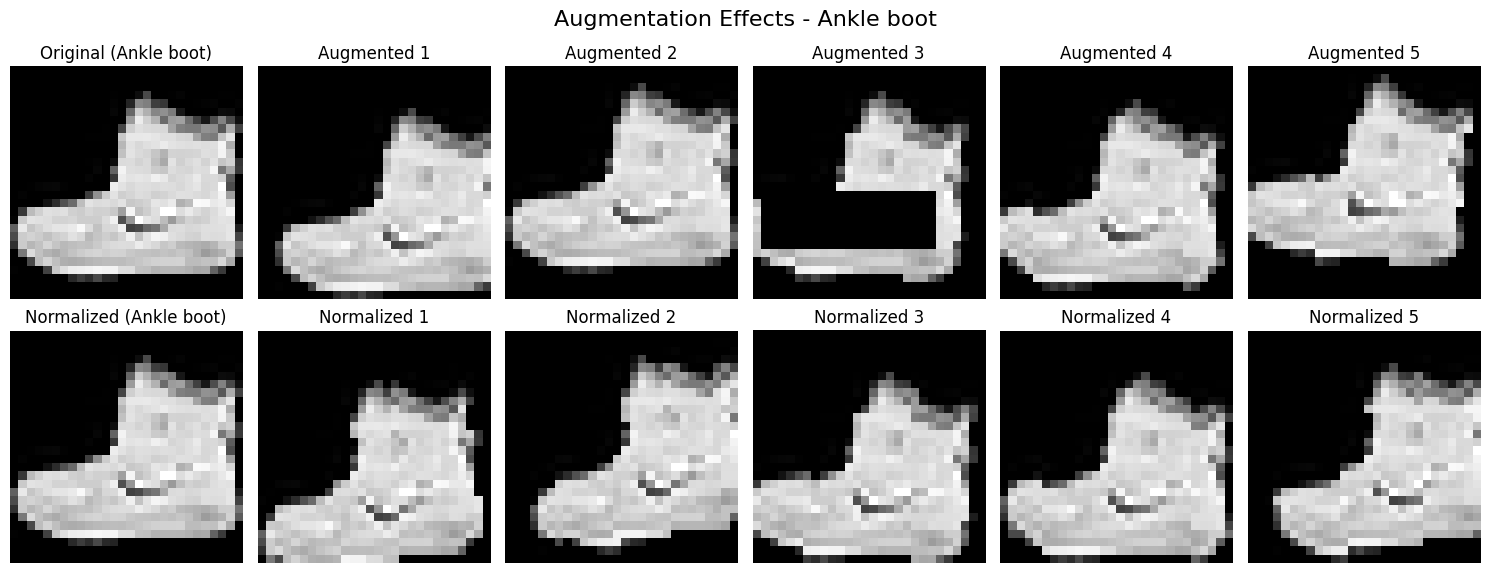


Augmented Statistics after Normalization
Original Mean: 0.2863
  Augmented Mean: 0.2245
Original Std: 0.3530
  Augmented Std: 1.1316
  Value Range: [-0.8112, 2.0219]


In [20]:
# Visualize Augmentation Effects
def visualize_augmentations(dataset, transform, class_names, num_samples=5):
  """ Visualize the Efferct of Data Augmentation """
  print(" === Visualizing Augmentation Effects === ")

  # Get a sample Image
  original_img, label = dataset[0]
  class_name = class_names[label]

  # Apply the Transform multiple times to see the variation
  fig, axes = plt.subplots(2, num_samples+1, figsize=(15, 6))

  # Original Image (First Column Top Row)
  axes[0,0].imshow(original_img.squeeze(), cmap='gray')
  axes[0,0].set_title(f'Original ({class_name})')
  axes[0,0].axis('off')

  # Normalized Original (First Column Bottom Row)
  normalized_original = val_transform(transforms.ToPILImage()(original_img))
  # Reverse Normalization (Convert Back for Visualization)
  denorm_img = normalized_original * image_stats['std'] + image_stats['mean']
  axes[1,0].imshow(denorm_img.squeeze(), cmap='gray')
  axes[1,0].set_title(f'Normalized ({class_name})')
  axes[1,0].axis('off')

  # Augmented Versions
  pil_img = transforms.ToPILImage()(original_img)

  for i in range(num_samples):
    augmented_img = transform(pil_img)
    # Reverse Normalization

    denorm_aug = augmented_img * image_stats['std'] + image_stats['mean']

    # Top Row: Effects before Normalization
    viz_transform = transforms.Compose(train_transform.transforms[: -1])
    viz_augmented = viz_transform(pil_img)


    axes[0, i+1].imshow(viz_augmented.squeeze(), cmap='gray')
    axes[0,i+1].set_title(f'Augmented {i+1}')
    axes[0,i+1].axis('off')


    axes[1, i+1].imshow(denorm_aug.squeeze().clamp(0,1), cmap='gray')
    axes[1, i+1].set_title(f'Normalized {i+1}')
    axes[1, i+1].axis('off')

  plt.suptitle(f'Augmentation Effects - {class_name}', fontsize=16)
  plt.tight_layout()
  plt.show()

# Visualize Augmentation Statistics
  augmented_values = []
  for _ in range(100):
    aug_img = transform(pil_img)
    augmented_values.extend(aug_img.flatten().numpy())

  augmented_values = np.array(augmented_values)

  print(f"\nAugmented Statistics after Normalization")
  print(f"Original Mean: {image_stats['mean']:.4f}")
  print(f"  Augmented Mean: {augmented_values.mean():.4f}")
  print(f"Original Std: {image_stats['std']:.4f}")
  print(f"  Augmented Std: {augmented_values.std():.4f}")
  print(f"  Value Range: [{augmented_values.min():.4f}, {augmented_values.max():.4f}]")

# Visualize Augmentation Effects
visualize_augmentations(train_data, train_transform, classes)

In [21]:
# Custom Dataset Class for MultiModal Data
class FashionMNISTCustom(Dataset):
  """
  Custom Dataset class for Fashion-MNIST with enhanced functionality
  Includes support for multimodal data integration

  """
  def __init__(self, dataset, transform=None, include_metadata=True):
    """
    Args:
        dataset: Original torchvision Fashion-MNIST dataset
        transform: Image transforms to apply
        include_metadata: Whether to include additional metadata
    """

    self.dataset = dataset
    self.transform = transform
    self.include_metadata = include_metadata

    # Class Information
    self.class_names = [ 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]

    # Precompute Class Distributions for Efficient Sampling
    self.class_counts = Counter()
    self.class_indices = {i: [] for i in range(len(self.class_names))}

    for idx in range(len(dataset)):
      _, label = dataset[idx]
      self.class_counts[label] += 1
      self.class_indices[label].append(idx)

    print(f"Custom Dataset Initialized:")
    print(f" Total Samples: {len(dataset)}")
    print(f" Classes: {len(self.class_names)} ")
    print(f"  Transfrom:{'Yes' if transform else 'No'}")
    print(f" Metadata: {'Enabled' if include_metadata else 'Disabled'}")

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    image, label = self.dataset[idx]

    # Apply Transform
    if self.transform:
      image = self.transform(transforms.ToPILImage()(image))

    # Prepeare return Data
    sample = {
        'image': image,
        'label': label,
        'class_name': self.class_names[label]
    }

    # Include Additional Metadata if Enabled

    if self.include_metadata:
      sample.update({
          'index' : idx,
          'class_frequency' : self.class_counts[label],
          'class_weight' : 1.0 / self.class_counts[label]
      })

    return sample

  def get_class_samples(self, class_idx, num_samples=5):
    """ Get a specified number of samples from a specific class """
    available_indices = self.class_indices[class_idx]
    selected_indices = np.random.choice(available_indices,
                                        size=min(num_samples, len(available_indices)),
                                        replace=False)
    return [self[idx] for idx in selected_indices]


  def get_class_distribution(self):
    """ Get the distribution of classes in the dataset """
    dist_data = []
    for class_idx, class_name in enumerate(self.class_names):
      dist_data.append({
          'class_idx': class_idx,
          'class_name': class_name,
          'count': self.class_counts[class_idx],
          'percentage': self.class_counts[class_idx] / len(self.dataset) * 100
      })
    return pd.DataFrame(dist_data)

# Create Custom Datsets

print("=== Creating Custom Datasets ===")
train_custom = FashionMNISTCustom(train_data, transform= train_transform)
val_custom = FashionMNISTCustom(test_data, transform= val_transform)

# Test the custom Dataset
sample = train_custom[0]
print(f"\nSample Structure:")
for key, value in sample.items():
  if key == 'image':
    print(f"  {key}: shape{value.shape}, dtype: {value.dtype}")
  else:
    print(f"  {key}: {value}")

=== Creating Custom Datasets ===
Custom Dataset Initialized:
 Total Samples: 60000
 Classes: 10 
  Transfrom:Yes
 Metadata: Enabled
Custom Dataset Initialized:
 Total Samples: 10000
 Classes: 10 
  Transfrom:Yes
 Metadata: Enabled

Sample Structure:
  image: shapetorch.Size([1, 28, 28]), dtype: torch.float32
  label: 9
  class_name: Ankle boot
  index: 0
  class_frequency: 6000
  class_weight: 0.00016666666666666666


In [22]:
# Cell 7: Efficient Data Loaders with Performance Optimization

def create_optimized_dataloaders(train_dataset, val_dataset, batch_size=64, num_workers=4):
  """
  Create optimized data loaders for training and validation

    Args:
        train_dataset, val_dataset: Custom dataset instances
        batch_size: Batch size for training
        num_workers: Number of worker processes for data loading
  """
  print("=== Creating Optimized Data Loaders ===")

  # Training Loader with Shuffling
  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers,
                            pin_memory = torch.cuda.is_available(),
                            drop_last = True,
                            persistent_workers = num_workers > 0
                            )

  # Validation Loader without shuffling
  val_loader = DataLoader(
      val_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=torch.cuda.is_available(),
      drop_last=False
  )

  print(f"Training Batches: {len(train_loader)}")
  print(f"Validation Batches: {len(val_loader)}")
  print(f"Batch Size: {batch_size}")
  print(f"Workers : {num_workers}")
  print(f"Pin Memory : {torch.cuda.is_available()}")

  return train_loader, val_loader

# Create Optimized Data Loaders
train_loader, val_loader = create_optimized_dataloaders(train_custom,
                                                        val_custom,
                                                        batch_size=64)

=== Creating Optimized Data Loaders ===
Training Batches: 937
Validation Batches: 157
Batch Size: 64
Workers : 4
Pin Memory : False


=== Data Loading Benchmark (50 batches) ===
Results:
  Total time: 5.16s
  Average batch time: 0.0001s
  Std batch time: 0.0001s
  Min batch time: 0.0001s
  Max batch time: 0.0009s
  Batches/second: 9.70


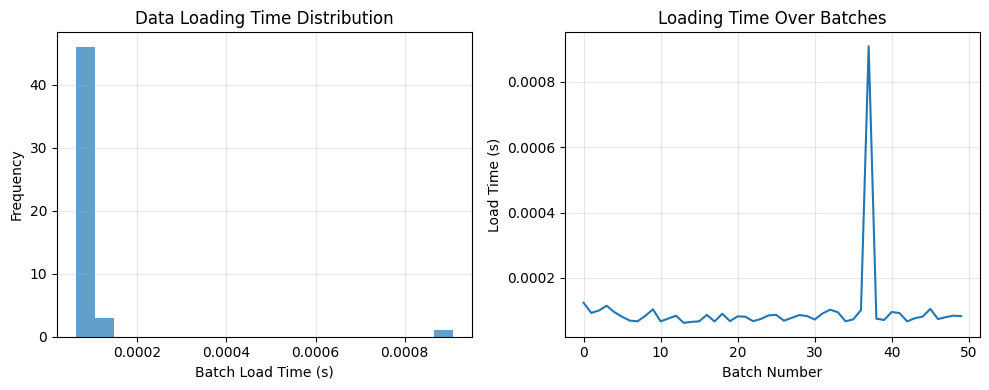

In [23]:

# Data Loading Performance Analysis
def benchmark_data_loading(data_loader, num_batches=50):
  """ Benchmark data Loading Performance """
  print(f"=== Data Loading Benchmark ({num_batches} batches) ===")

  import matplotlib.pyplot as plt
  import time

  times = []

  # Warm-Up
  for i, batch in enumerate(data_loader):
    if i >= 3:
      break

  start_time = time.time()

  for i, batch in enumerate(data_loader):
    batch_start = time.time()

    # Simulate some processing time
    images = batch['image']
    labels = batch['label']

    # Move to a GPU if Available(pin_memory effect tesing)
    if torch.cuda.is_available():
      images = images.cuda(non_blocking=True)
      labels = labels.cuda(non_blocking=True)

    batch_time = time.time() - batch_start
    times.append(batch_time)

    if i >= num_batches - 1:
      break

  total_time = time.time() - start_time

  times = np.array(times)

  print(f"Results:")
  print(f"  Total time: {total_time:.2f}s")
  print(f"  Average batch time: {times.mean():.4f}s")
  print(f"  Std batch time: {times.std():.4f}s")
  print(f"  Min batch time: {times.min():.4f}s")
  print(f"  Max batch time: {times.max():.4f}s")
  print(f"  Batches/second: {len(times)/total_time:.2f}")

  # Plot timing distribution
  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.hist(times, bins=20, alpha=0.7)
  plt.xlabel('Batch Load Time (s)')
  plt.ylabel('Frequency')
  plt.title('Data Loading Time Distribution')
  plt.grid(True, alpha=0.3)

  plt.subplot(1, 2, 2)
  plt.plot(times)
  plt.xlabel('Batch Number')
  plt.ylabel('Load Time (s)')
  plt.title('Loading Time Over Batches')
  plt.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

  return times

# Benchmark data loading performance
loading_times = benchmark_data_loading(train_loader)





In [24]:
# Save the pre-processing configuration

def save_preprocessing_config():
  """ Save the Pre-Processing Configuration for Reproducibility """

  config = {
      'image_statistics' : image_stats,
      'augmentation_level' : 'medium',
      'transforms' : {
          'train' : str(train_transform),
          'validation' : str(val_transform)
      },
      'data_loader_config' : {
          'batch_size' : 64,
          'num_workers' : 4,
          'pin_memory' : torch.cuda.is_available(),
          'shuffle_train' : True,
          'drop_last' : True
      },
      'datast_info' : {
          'train_samples' : len(train_custom),
          'val_samples' : len(val_custom),
          'num_classes' : len(classes),
          'class_names' : classes
      }
  }

  # Save to JSON

  os.makedirs('./data/processed', exist_ok=True)
  with open('./data/processed/preprocessing_config.json', 'w') as f:
    json.dump(config, f, indent=2, default=str)

  # save class_distribution

  class_dist = train_custom.get_class_distribution()
  class_dist.to_csv('./data/processed/class_distribution.csv', index=False)

  print("=== Preprocessing Configuration Saved ===")
  print("Files saved:")
  print("  - ./data/processed/preprocessing_config.json")
  print("  - ./data/processed/class_distribution.csv")

  return config

preprocessing_config = save_preprocessing_config()





=== Preprocessing Configuration Saved ===
Files saved:
  - ./data/processed/preprocessing_config.json
  - ./data/processed/class_distribution.csv


In [25]:
#  Week 2 Progress Summary
print("\n" + "="*50)
print("         WEEK 2, DAY 1 PROGRESS SUMMARY")
print("="*50)

print("\n✅ COMPLETED:")
print("  ✓ Image statistics analysis and normalization calculation")
print("  ✓ Multi-level data augmentation strategy implementation")
print("  ✓ Custom dataset class with multimodal support")
print("  ✓ Optimized data loaders with performance tuning")
print("  ✓ Data loading benchmarking and analysis")
print("  ✓ Preprocessing configuration serialization")

print("\n📊 KEY METRICS:")
print(f"  • Image normalization: mean={image_stats['mean']:.4f}, std={image_stats['std']:.4f}")
print(f"  • Training samples: {len(train_custom):,}")
print(f"  • Validation samples: {len(val_custom):,}")
print(f"  • Average loading time: {loading_times.mean():.4f}s per batch")
print(f"  • Data loading rate: {64/loading_times.mean():.1f} samples/second")

print("\n🔄 NEXT STEPS (Day 2):")
print("  • Text preprocessing pipeline development")
print("  • Review text cleaning and tokenization")
print("  • Multimodal dataset integration")
print("  • Memory usage optimization")

print("\n💡 KEY LEARNINGS:")
print("  • Fashion-MNIST has consistent pixel statistics across classes")
print("  • Medium augmentation provides good balance for this dataset")
print("  • Custom dataset classes enable flexible multimodal integration")
print("  • Proper data loading optimization is crucial for training efficiency")

print("\n⚠️  CONSIDERATIONS:")
print("  • Current pipeline optimized for Fashion-MNIST (28x28 grayscale)")
print("  • Real product images would need different preprocessing")
print("  • Memory usage scales with batch size and number of workers")
print("  • GPU utilization depends on effective data pipeline performance")


         WEEK 2, DAY 1 PROGRESS SUMMARY

✅ COMPLETED:
  ✓ Image statistics analysis and normalization calculation
  ✓ Multi-level data augmentation strategy implementation
  ✓ Custom dataset class with multimodal support
  ✓ Optimized data loaders with performance tuning
  ✓ Data loading benchmarking and analysis
  ✓ Preprocessing configuration serialization

📊 KEY METRICS:
  • Image normalization: mean=0.2863, std=0.3530
  • Training samples: 60,000
  • Validation samples: 10,000
  • Average loading time: 0.0001s per batch
  • Data loading rate: 643329.0 samples/second

🔄 NEXT STEPS (Day 2):
  • Text preprocessing pipeline development
  • Review text cleaning and tokenization
  • Multimodal dataset integration
  • Memory usage optimization

💡 KEY LEARNINGS:
  • Fashion-MNIST has consistent pixel statistics across classes
  • Medium augmentation provides good balance for this dataset
  • Custom dataset classes enable flexible multimodal integration
  • Proper data loading optimization